In [34]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from pathlib import Path
from pprint import pprint
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# mycode
from repo import REPO
from ml_utilities.output_loader.result_loader import SweepResult, JobResult
from ml_utilities.output_loader import create_job_output_loader
from ml_utilities.output_loader.plot import plot_sweep_summary, plot_data_log_values
from tflearning.mode_connectivity.instability_analysis import InstabilityAnalyzer
from tflearning.mode_connectivity.plot import plot_barriers, plot_instability, plot_distances

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 17-CF10-Resnet Linear mode connectivity

Reference: Frankle, Jonathan, Gintare Karolina Dziugaite, Daniel M. Roy, and Michael Carbin. 2020. “Linear Mode Connectivity and the Lottery Ticket Hypothesis.” arXiv. http://arxiv.org/abs/1912.05671.

In this notebook I reproduce the results for resnet20 on CIFAR10 of the Frankle paper. 
I also do the same analysis without image augmentations, to check what fraction of the instability is due to data augmentation.


## 17.2. With Data Augmentation

### With Batchnorm update

In [35]:
spec = 'cf10-resnet-augmentOn-bnUpdateOn'
path = '/system/user/beck/pwbeck/projects/regularization/tflearning/outputs/IA-B-cifar10-17.2.1-resnet-B--230120_141533'
insta = InstabilityAnalyzer.reload(sweep_result_dir=path, instability_folder_suffix='1')

In [36]:
# load training jobs
sweepr = insta.instability_sweep
mainjob = insta.main_training_job

In [37]:
mainjob.get_summary(log_source='val', col_sel='Accuracy')

,best_train_step,best_val_score,Accuracy-train_step-44500,seed
IA-A-cifar10-17.2.1-resnet-B--230120_134950,44500,0.9166,0.9166,0


In [38]:
sweepr.get_summary()

,best_train_step,best_val_score,trainer.resume_training.checkpoint_idx,seed
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-0-seed-1--230120_161833,64000,0.9134,0,1
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-100-seed-1--230120_161547,35000,0.9132,100,1
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-1000-seed-1--230120_145506,43500,0.9124,1000,1
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-10000-seed-1--230120_141544,36500,0.9178,10000,1
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-15000-seed-1--230120_165753,62500,0.9152,15000,1
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-2000-seed-1--230120_170039,38500,0.9126,2000,1
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-250-seed-1--230120_153357,37000,0.9124,250,1
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-50-seed-1--230120_145151,42000,0.9128,50,1
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-500-seed-1--230120_153635,55000,0.9178,500,1
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-5000-seed-1--230120_141544,63000,0.9162,5000,1


In [39]:
# mainjob.get_data_log('val')

In [40]:
df = insta.combined_results_dfs['datasets'].loc['default_params']
df

datasets                                                                                                   val  \
score                                                                                     interpolation_scores   
alpha                                                                                                     -0.1   
init_model_idx_k job                                                seeds  model_idxes                           
0                IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-0     (1, 0) (64000, 44500)             0.126953   
                                                                           (64001, 64001)             0.126953   
50               IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-50    (1, 0) (42000, 44500)             0.140234   
                                                                           (64000, 64001)             0.140234   
100              IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-100   (1, 0) (35000, 44500)             0.133008   
                                                                           (64000, 64001)             0.133008   
250              IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-250   (1, 0) (37000, 44500)             0.137305   
                                                                           (64000, 64001)             0.137305   
500              IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-500   (1, 0) (55000, 44500)             0.133008   
                                                                           (64000, 64001)             0.133008   
1000             IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-1000  (1, 0) (43500, 44500)             0.130469   
                                                                           (64001, 64001)             0.130469   
2000             IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-2000  (1, 0) (38500, 44500)             0.134180   
                                                                           (64000, 64001)             0.134180   
5000             IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-5000  (1, 0) (63000, 44500)             0.134766   
                                                                           (64000, 64001)             0.134766   
10000            IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-10000 (1, 0) (36500, 44500)             0.128711   
                                                                           (64000, 64001)             0.128711   
15000            IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-15000 (1, 0) (62500, 44500)             0.121680   
                                                                           (64000, 64001)             0.121680   

datasets                                                                                             \
score                                                                                                 
alpha                                                                                           0.0   
init_model_idx_k job                                                seeds  model_idxes                
0                IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-0     (1, 0) (64000, 44500)  0.120117   
                                                                           (64001, 64001)  0.120117   
50               IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-50    (1, 0) (42000, 44500)  0.131250   
                                                                           (64000, 64001)  0.131250   
100              IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-100   (1, 0) (35000, 44500)  0.120508   
                                                                           (64000, 64001)  0.120508   
250              IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-250   (1, 0) (37000, 44500)  0.127344   
                                                                           (64000, 64001)  0.127344   
500              IA-B-cifar

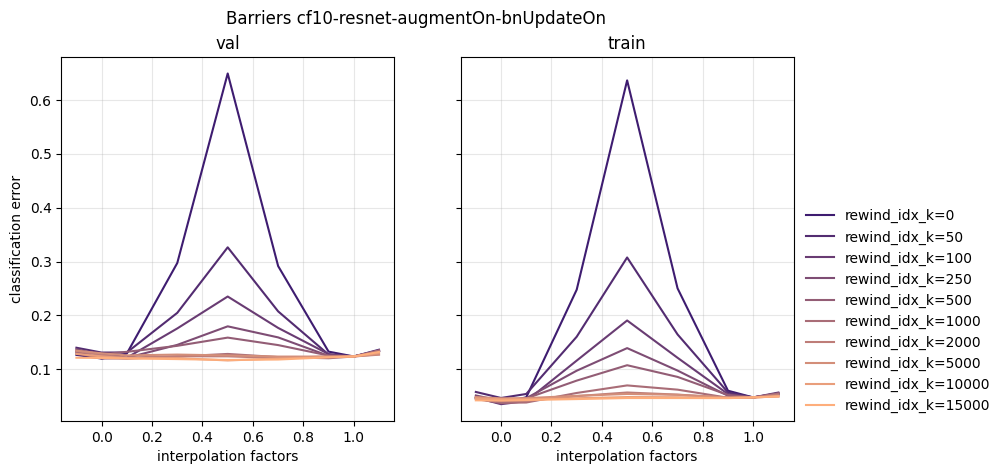

In [41]:
f = plot_barriers(instability_df=insta.combined_results_dfs['datasets'].loc['default_params'], title=f'Barriers {spec}', save_format='png')

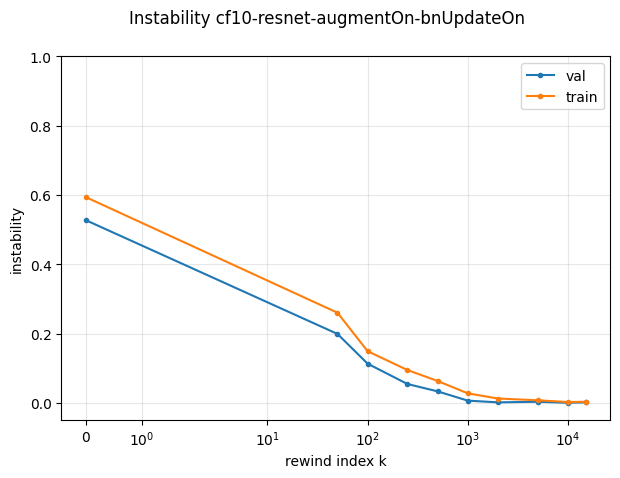

In [42]:
f = plot_instability(instability_df=insta.combined_results_dfs['datasets'].loc['default_params'], title=f'Instability {spec}', x_scale='symlog', save_format='png')

In [43]:
df = insta.combined_results_dfs['distances'].loc['default_params']
df

distances                                                                                 l2distance  \
init_model_idx_k job                                                seeds  model_idxes                 
0                IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-0     (1, 0) (64000, 44500)  70.838951   
                                                                           (64001, 64001)  70.838951   
50               IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-50    (1, 0) (42000, 44500)  65.706688   
                                                                           (64000, 64001)  65.706688   
100              IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-100   (1, 0) (35000, 44500)  62.257004   
                                                                           (64000, 64001)  62.257004   
250              IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-250   (1, 0) (37000, 44500)  58.755894   
                                                                           (64000, 64001)  58.755894   
500              IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-500   (1, 0) (55000, 44500)  54.137508   
                                                                           (64000, 64001)  54.137508   
1000             IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-1000  (1, 0) (43500, 44500)  48.692684   
                                                                           (64001, 64001)  48.692684   
2000             IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-2000  (1, 0) (38500, 44500)  43.983902   
                                                                           (64000, 64001)  43.983902   
5000             IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-5000  (1, 0) (63000, 44500)  36.917591   
                                                                           (64000, 64001)  36.917591   
10000            IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-10000 (1, 0) (36500, 44500)  31.971260   
                                                                           (64000, 64001)  31.971260   
15000            IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-15000 (1, 0) (62500, 44500)  29.056137   
                                                                           (64000, 64001)  29.056137   

distances                                                                                 cosinesimilarity  
init_model_idx_k job                                                seeds  model_idxes                      
0                IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-0     (1, 0) (64000, 44500)         0.234376  
                                                                           (64001, 64001)         0.234376  
50               IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-50    (1, 0) (42000, 44500)         0.340437  
                                                                           (64000, 64001)         0.340437  
100              IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-100   (1, 0) (35000, 44500)         0.407717  
                                                                           (64000, 64001)         0.407717  
250              IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-250   (1, 0) (37000, 44500)         0.472541  
                                                                           (64000, 64001)         0.472541  
500              IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-500   (1, 0) (55000, 44500)         0.552219  
                                                                           (64000, 64001)         0.552219  
1000             IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-1000  (1, 0) (43500, 44500)         0.638172  
                                                                           (64001, 64001)         0.638172  
2000             IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-2000  (1, 0) (38500, 44500)         0.705127  
                                                                           (

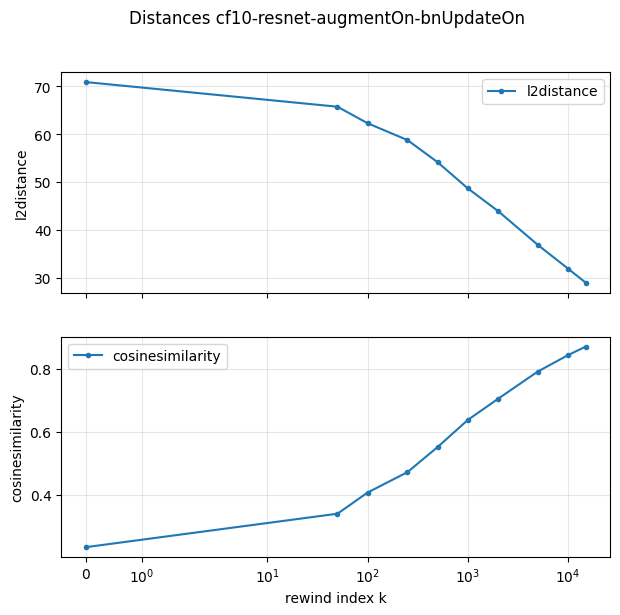

In [44]:
f = plot_distances(distances_df=insta.combined_results_dfs['distances'].loc['default_params'], title=f'Distances {spec}', save_format='png')

### Without Batchnorm update

In [45]:
spec = 'cf10-resnet-augmentOn-bnUpdateOff'
path = '/system/user/beck/pwbeck/projects/regularization/tflearning/outputs/IA-B-cifar10-17.2.1-resnet-B--230120_141533'
insta = InstabilityAnalyzer.reload(sweep_result_dir=path, instability_folder_suffix='nobn-1')

In [46]:
# load training jobs
sweepr = insta.instability_sweep
mainjob = insta.main_training_job

In [47]:
mainjob.get_summary(log_source='val', col_sel='Accuracy')

,best_train_step,best_val_score,Accuracy-train_step-44500,seed
IA-A-cifar10-17.2.1-resnet-B--230120_134950,44500,0.9166,0.9166,0


In [48]:
sweepr.get_summary()

,best_train_step,best_val_score,trainer.resume_training.checkpoint_idx,seed
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-0-seed-1--230120_161833,64000,0.9134,0,1
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-100-seed-1--230120_161547,35000,0.9132,100,1
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-1000-seed-1--230120_145506,43500,0.9124,1000,1
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-10000-seed-1--230120_141544,36500,0.9178,10000,1
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-15000-seed-1--230120_165753,62500,0.9152,15000,1
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-2000-seed-1--230120_170039,38500,0.9126,2000,1
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-250-seed-1--230120_153357,37000,0.9124,250,1
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-50-seed-1--230120_145151,42000,0.9128,50,1
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-500-seed-1--230120_153635,55000,0.9178,500,1
IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-5000-seed-1--230120_141544,63000,0.9162,5000,1


In [49]:
# mainjob.get_data_log('val')

In [50]:
df = insta.combined_results_dfs['datasets'].loc['default_params']
df

datasets                                                                                                   val  \
score                                                                                     interpolation_scores   
alpha                                                                                                     -0.1   
init_model_idx_k job                                                seeds  model_idxes                           
0                IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-0     (1, 0) (64000, 44500)             0.902930   
                                                                           (64001, 64001)             0.902930   
50               IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-50    (1, 0) (42000, 44500)             0.902930   
                                                                           (64000, 64001)             0.902930   
100              IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-100   (1, 0) (35000, 44500)             0.902930   
                                                                           (64000, 64001)             0.902930   
250              IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-250   (1, 0) (37000, 44500)             0.902930   
                                                                           (64000, 64001)             0.902930   
500              IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-500   (1, 0) (55000, 44500)             0.902930   
                                                                           (64000, 64001)             0.902930   
1000             IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-1000  (1, 0) (43500, 44500)             0.902930   
                                                                           (64001, 64001)             0.902930   
2000             IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-2000  (1, 0) (38500, 44500)             0.106836   
                                                                           (64000, 64001)             0.106836   
5000             IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-5000  (1, 0) (63000, 44500)             0.094727   
                                                                           (64000, 64001)             0.094727   
10000            IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-10000 (1, 0) (36500, 44500)             0.092773   
                                                                           (64000, 64001)             0.092773   
15000            IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-15000 (1, 0) (62500, 44500)             0.093359   
                                                                           (64000, 64001)             0.093359   

datasets                                                                                             \
score                                                                                                 
alpha                                                                                           0.0   
init_model_idx_k job                                                seeds  model_idxes                
0                IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-0     (1, 0) (64000, 44500)  0.091211   
                                                                           (64001, 64001)  0.091211   
50               IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-50    (1, 0) (42000, 44500)  0.090820   
                                                                           (64000, 64001)  0.090820   
100              IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-100   (1, 0) (35000, 44500)  0.093750   
                                                                           (64000, 64001)  0.093750   
250              IA-B-cifar10-17.2.1-resnet-B--checkpoint_idx-250   (1, 0) (37000, 44500)  0.091016   
                                                                           (64000, 64001)  0.091016   
500              IA-B-cifar

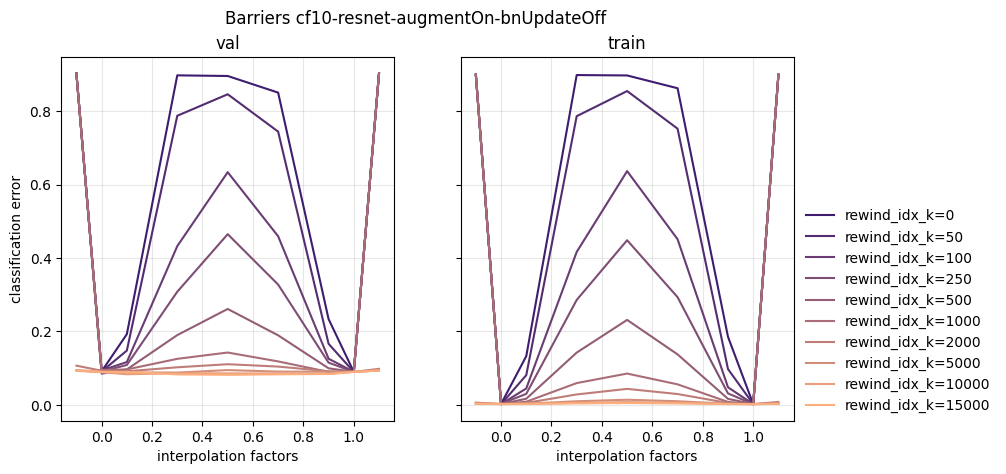

In [51]:
f = plot_barriers(instability_df=insta.combined_results_dfs['datasets'].loc['default_params'], title=f'Barriers {spec}', save_format='png')

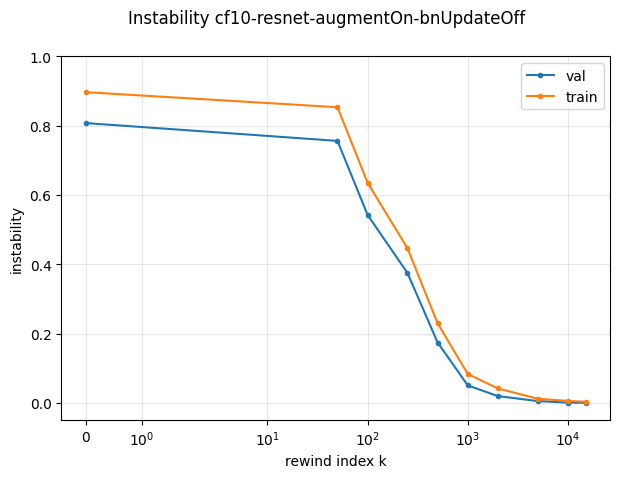

In [52]:
f = plot_instability(instability_df=insta.combined_results_dfs['datasets'].loc['default_params'], title=f'Instability {spec}', x_scale='symlog', save_format='png')

## 17.3 Without Data Augmentation

### With Batchnorm update

In [53]:
spec = 'cf10-resnet-augmentOff-bnUpdateOn'
path = '/system/user/beck/pwbeck/projects/regularization/tflearning/outputs/IA-B-cifar10-17.3.0-resnet-B-notransform--230120_141717'
insta = InstabilityAnalyzer.reload(sweep_result_dir=path, instability_folder_suffix='1')

In [54]:
# load training jobs
sweepr = insta.instability_sweep
mainjob = insta.main_training_job

In [55]:
mainjob.get_summary(log_source='val', col_sel='Accuracy')

,best_train_step,best_val_score,Accuracy-train_step-47000,seed
IA-A-cifar10-17.3.0-resnet-B-notransform--230120_135031,47000,0.8416,0.8416,0


In [56]:
sweepr.get_summary()

,best_train_step,best_val_score,trainer.resume_training.checkpoint_idx,seed
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-0-seed-1--230120_161826,56500,0.8452,0,1
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-100-seed-1--230120_161619,43000,0.8484,100,1
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-1000-seed-1--230120_145609,51000,0.8442,1000,1
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-10000-seed-1--230120_141728,52000,0.8452,10000,1
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-15000-seed-1--230120_165739,34500,0.8446,15000,1
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-2000-seed-1--230120_170011,46000,0.8386,2000,1
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-250-seed-1--230120_153454,56500,0.8500,250,1
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-50-seed-1--230120_145309,36000,0.8416,50,1
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-500-seed-1--230120_153713,57000,0.8456,500,1
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-5000-seed-1--230120_141728,57000,0.8422,5000,1


In [57]:
df = insta.combined_results_dfs['datasets'].loc['default_params']
df

datasets                                                                                                   val  \
score                                                                                     interpolation_scores   
alpha                                                                                                     -0.1   
init_model_idx_k job                                                seeds  model_idxes                           
0                IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (56500, 47000)             0.167187   
                                                                           (64001, 64001)             0.167187   
50               IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (36000, 47000)             0.164258   
                                                                           (64000, 64001)             0.166797   
100              IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (43000, 47000)             0.162695   
                                                                           (64000, 64001)             0.162695   
250              IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (56500, 47000)             0.169336   
                                                                           (64000, 64001)             0.169336   
500              IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (57000, 47000)             0.160938   
                                                                           (64000, 64001)             0.160938   
1000             IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (51000, 47000)             0.167187   
                                                                           (64001, 64001)             0.167187   
2000             IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (46000, 47000)             0.175195   
                                                                           (64000, 64001)             0.175195   
5000             IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (57000, 47000)             0.170312   
                                                                           (64000, 64001)             0.170312   
10000            IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (52000, 47000)             0.167969   
                                                                           (64000, 64001)             0.167969   
15000            IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (34500, 47000)             0.163086   
                                                                           (64000, 64001)             0.163086   

datasets                                                                                             \
score                                                                                                 
alpha                                                                                           0.0   
init_model_idx_k job                                                seeds  model_idxes                
0                IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (56500, 47000)  0.162891   
                                                                           (64001, 64001)  0.162891   
50               IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (36000, 47000)  0.159570   
                                                                           (64000, 64001)  0.156445   
100              IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (43000, 47000)  0.157227   
                                                                           (64000, 64001)  0.157227   
250              IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (56500, 47000)  0.157227   
                                                                           (64000, 64001)  0.157227   
500              IA-B-cifar

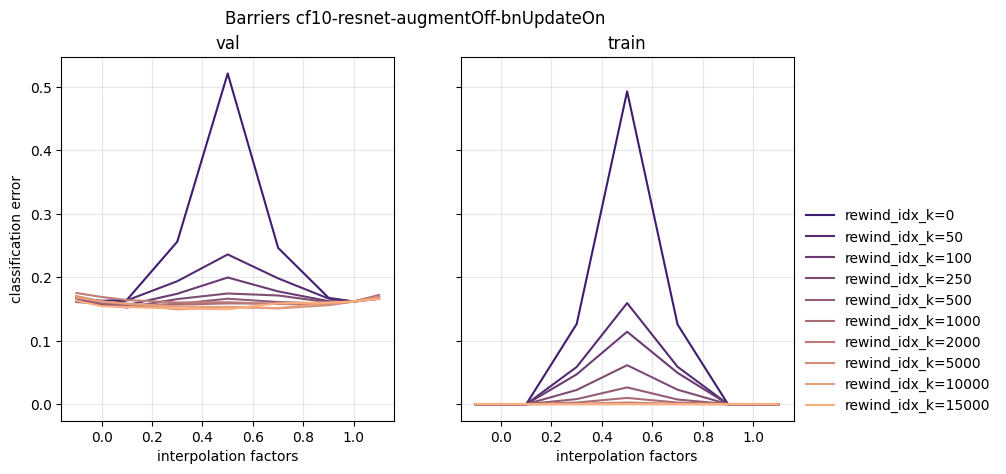

In [58]:
f = plot_barriers(instability_df=insta.combined_results_dfs['datasets'].loc['default_params'], title=f'Barriers {spec}', save_format='png')

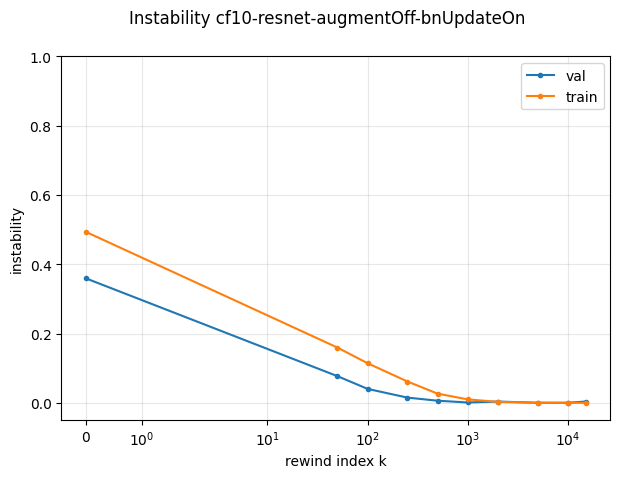

In [59]:
f = plot_instability(instability_df=insta.combined_results_dfs['datasets'].loc['default_params'], title=f'Instability {spec}', x_scale='symlog', save_format='png')

### Without Batchnorm update

In [60]:
spec = 'cf10-resnet-augmentOff-bnUpdateOff'
path = '/system/user/beck/pwbeck/projects/regularization/tflearning/outputs/IA-B-cifar10-17.3.0-resnet-B-notransform--230120_141717'
insta = InstabilityAnalyzer.reload(sweep_result_dir=path, instability_folder_suffix='nobn-1')

In [61]:
# load training jobs
sweepr = insta.instability_sweep
mainjob = insta.main_training_job

In [62]:
mainjob.get_summary(log_source='val', col_sel='Accuracy')

,best_train_step,best_val_score,Accuracy-train_step-47000,seed
IA-A-cifar10-17.3.0-resnet-B-notransform--230120_135031,47000,0.8416,0.8416,0


In [63]:
sweepr.get_summary()

,best_train_step,best_val_score,trainer.resume_training.checkpoint_idx,seed
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-0-seed-1--230120_161826,56500,0.8452,0,1
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-100-seed-1--230120_161619,43000,0.8484,100,1
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-1000-seed-1--230120_145609,51000,0.8442,1000,1
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-10000-seed-1--230120_141728,52000,0.8452,10000,1
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-15000-seed-1--230120_165739,34500,0.8446,15000,1
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-2000-seed-1--230120_170011,46000,0.8386,2000,1
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-250-seed-1--230120_153454,56500,0.8500,250,1
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-50-seed-1--230120_145309,36000,0.8416,50,1
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-500-seed-1--230120_153713,57000,0.8456,500,1
IA-B-cifar10-17.3.0-resnet-B-notransform--checkpoint_idx-5000-seed-1--230120_141728,57000,0.8422,5000,1


In [64]:
df = insta.combined_results_dfs['datasets'].loc['default_params']
df

datasets                                                                                                   val  \
score                                                                                     interpolation_scores   
alpha                                                                                                     -0.1   
init_model_idx_k job                                                seeds  model_idxes                           
0                IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (56500, 47000)             0.902930   
                                                                           (64001, 64001)             0.902930   
50               IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (36000, 47000)             0.902930   
                                                                           (64000, 64001)             0.902930   
100              IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (43000, 47000)             0.199414   
                                                                           (64000, 64001)             0.199414   
250              IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (56500, 47000)             0.177539   
                                                                           (64000, 64001)             0.177539   
500              IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (57000, 47000)             0.902930   
                                                                           (64000, 64001)             0.902930   
1000             IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (51000, 47000)             0.178711   
                                                                           (64001, 64001)             0.178711   
2000             IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (46000, 47000)             0.178125   
                                                                           (64000, 64001)             0.178125   
5000             IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (57000, 47000)             0.173242   
                                                                           (64000, 64001)             0.173242   
10000            IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (52000, 47000)             0.169336   
                                                                           (64000, 64001)             0.169336   
15000            IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (34500, 47000)             0.164648   
                                                                           (64000, 64001)             0.164648   

datasets                                                                                             \
score                                                                                                 
alpha                                                                                           0.0   
init_model_idx_k job                                                seeds  model_idxes                
0                IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (56500, 47000)  0.162305   
                                                                           (64001, 64001)  0.162305   
50               IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (36000, 47000)  0.157617   
                                                                           (64000, 64001)  0.157031   
100              IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (43000, 47000)  0.159375   
                                                                           (64000, 64001)  0.159375   
250              IA-B-cifar10-17.3.0-resnet-B-notransform--check... (1, 0) (56500, 47000)  0.156836   
                                                                           (64000, 64001)  0.156836   
500              IA-B-cifar

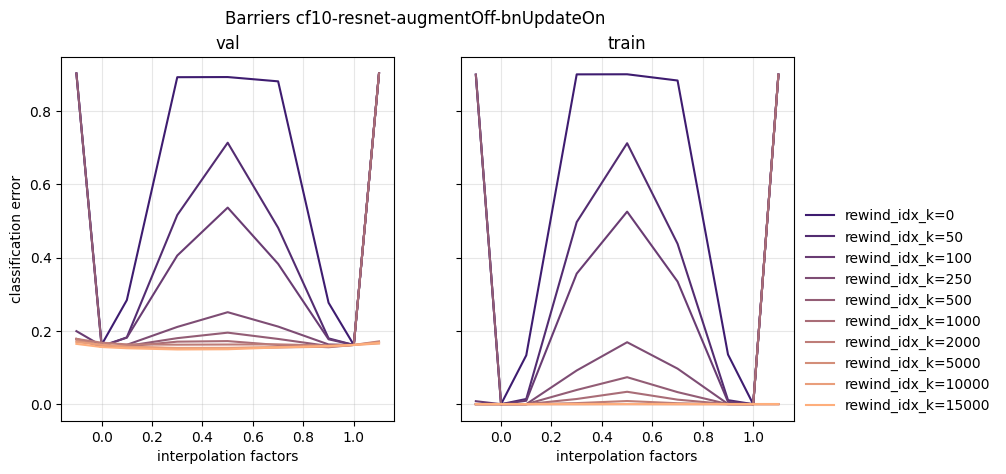

In [65]:
f = plot_barriers(instability_df=insta.combined_results_dfs['datasets'].loc['default_params'], title=f'Barriers {spec}', save_format='png')

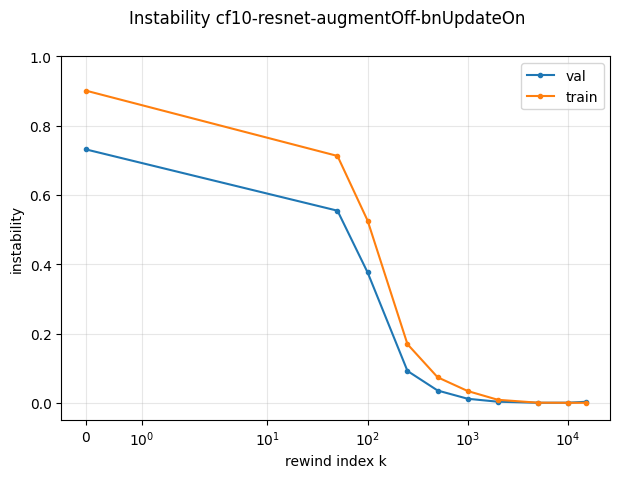

In [66]:
f = plot_instability(instability_df=insta.combined_results_dfs['datasets'].loc['default_params'], title=f'Instability {spec}', x_scale='symlog', save_format='png')